In [1]:
import re
import numpy as np
import tensorflow as tf
import pandas as pd
from icecream import ic
import time

from Attention import *

In [2]:
find_tokens = re.compile(r"[\w']+|[.,!?:;\[\]\(\)]")

def load_tokens(tokens_file):
    """
        Load the pre-trained word embeddings from the embedding file
        """
    # Load the word tokens
    tokens = pd.read_csv(tokens_file, index_col=0)
    tokens = tokens.index.values
    tokens_dict = {}
    tokens_dict['to_token'] = {token: i for i, token in enumerate(tokens)}
    tokens_dict['to_word'] = {i: token for i, token in enumerate(tokens)}
    return tokens_dict

def sim_tokenize(text, tokens_dict):
    """
        Tokenize the text and return the token indices
        """
    # Tokenize the text
    tokens = find_tokens.findall(text.lower())

    # Get the token indices
    tokens_indices = [tokens_dict['to_token'][token] for token in tokens]
    tokens_indices.insert(0, tokens_dict['to_token']['<start>'])
    tokens_indices.append(tokens_dict['to_token']['<end>'])
    [tokens_indices.append(tokens_dict['to_token']['<pad>']) for i in range(10)]
    return tokens_indices

def detokenize(tokens_indices, tokens_dict):
    """
        Convert the token indices to text
        """
    # Detokenize the text
    tokens = [tokens_dict['to_word'][i] for i in tokens_indices]
    text = ' '.join(tokens).replace('<pad>', '')
    return text

def benchmark(func, verbose=False):
    """
        Decorator to benchmark a function
        """
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        if verbose:
            print('{} took {} seconds'.format(func.__name__, end - start))
        return end - start, result
    return wrapper


In [3]:
tok = load_tokens('tokens.csv')
ic("loaded tokens")

ic| 'loaded tokens'


'loaded tokens'

In [4]:
tokenized = sim_tokenize('I am a test sentence.', tok)
rebuilt = detokenize(tokenized, tok)
print(f"Tokenized: {tokenized}")
print(f"Rebuilt: {rebuilt}")

Tokenized: [3, 11, 166, 12, 870, 4325, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Rebuilt: <start> i am a test sentence . <end>          


In [5]:
# q:  (128, 8, 96, 16) k:  (128, 8, 96, 16) v:  (128, 8, 96, 16)
x = tf.random.uniform((128, 96, 128))

# mha = MultiHeadAttention(128, 8)

# output, attn = mha(x, x, x, None)
# print(output.shape, attn.shape)

In [6]:
# q:  (128, 8, 96, 16) k:  (128, 8, 96, 16) v:  (128, 8, 96, 16)
x = tf.random.uniform((128, 96, 128))

# mha = Fastformer_MultiHeadAttention(128, 8, 96)

# output = mha(x, x, x, None)
# print(output.shape, attn.shape)


In [7]:
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self, feature_map):
        super(LinearAttention, self).__init__()
        self.feature_map = feature_map

    def build(self, input_shape):
        self.wQ = self.add_weight(name='wQ', shape=(
            input_shape[-1][-1], input_shape[-1][-1]), initializer='glorot_uniform')
        self.wK = self.add_weight(name='wK', shape=(
            input_shape[-1][-1], input_shape[-1][-1]), initializer='glorot_uniform')
        self.wV = self.add_weight(name='wV', shape=(
            input_shape[-1][-1], input_shape[-1][-1]), initializer='glorot_uniform')

    def call(self, inputs, **kwargs):
        # inputs: [q, k, v] for each: (batch_size, seq_len, d_model)
        q = tf.matmul(inputs[0], self.wQ)
        k = tf.matmul(inputs[1], self.wK)
        v = tf.matmul(inputs[2], self.wV)

        fQ = self.feature_map(q)
        fK = self.feature_map(k)
                
        return self.linear_attention(fQ, fK, v)

    # @tf.custom_gradient
    def linear_attention(self, q, k, v):
        """
            Compute the linear attention
        """

        Z = 1/tf.einsum('bsi,bsi->bsi', q, tf.cumsum(k, axis=1))
        S = tf.cumsum(tf.einsum('bsi,bsi->bsi', q, v), axis=1)

        Vp = tf.multiply(q, S)
        Vp = tf.realdiv(Vp, Z)

        return Vp




In [8]:
# q:  (16, 8, 96, 16) k:  (16, 8, 96, 16) v:  (16, 8, 96, 16)
x = tf.random.uniform((16, 8, 96, 16))

lat = tf.keras.metrics.Mean()
sdpat = tf.keras.metrics.Mean()

for i in range(1000):
    la_time, _ = benchmark(AttentionUtils.build_linear_attention())(x, x, x, None)
    sdpa_time, _ = benchmark(AttentionUtils.scaled_dot_product_attention)(x, x, x, None)

    lat(la_time)
    sdpat(sdpa_time)

print(f"Linear Attention: {lat.result()}")
print(f"Scaled Dot Product Attention: {sdpat.result()}")


Linear Attention: 0.0015714981127530336
Scaled Dot Product Attention: 0.005390692502260208


In [9]:
# q:  (16, 96, 128) k: (16, 96, 128) v: (16, 96, 128)

q = tf.constant([[[1], [1], [0], [0]]], dtype=tf.float32)
k = tf.constant([[[0], [0], [1], [0]]], dtype=tf.float32)
v = tf.constant([[[1], [0], [0], [1]]], dtype=tf.float32)

attn = LinearAttention(offsetElu)
@tf.function
def trace(attn, q, k, v):
    out = attn([q, k, v])
    # ic(tf.shape(out))
    # ic(x, out)


NameError: name 'offsetElu' is not defined

In [ ]:
logdir = "logs/scratch/" + "1"
writer = tf.summary.create_file_writer(logdir)
tf.summary.trace_on(graph=True, profiler=True)

z = trace(attn, q, k, v)

with writer.as_default():
    tf.summary.trace_export(
        name="my_func_trace",
        step=0,
        profiler_outdir=logdir)


ic| x: array([ 0.2 , -0.2 ,  0.5 ,  0.1 ,  0.1 ,  0.05])
ic| softmax(x): array([0.17572958, 0.11779506, 0.23721012, 0.1590067 , 0.1590067 ,
                       0.15125185])
    softmax(x).sum(): 1.0
ic| other(x): array([ 0.20728218, -0.1389454 ,  0.69950419,  0.09377834,  0.09377834,
                      0.04460236])
    other(x).sum(): 1.0


<BarContainer object of 6 artists>

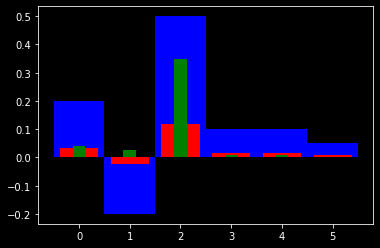

In [38]:
x = np.array([0.2, -0.2, 0.5, 0.1, 0.1, 0.05])
y = np.random.normal(size=(4,))


def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def other(x):
    e_x = x * np.exp(x)
    return e_x / e_x.sum()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def elu(x):
    return np.where(x > 0, x, np.exp(x) - 1)

def relu(x):
    return np.where(x > 0, x, 0)

ic(x)
ic(softmax(x), softmax(x).sum())
ic(other(x), other(x).sum())

plt.bar(range(x.shape[0]), x, color='b', width=1)
plt.bar(range(x.shape[0]), x*softmax(x), color='r', width=0.75)
plt.bar(range(x.shape[0]), x*other(x), color='g', width=0.25)


In [85]:
x = np.random.normal(size=(4,2))
ic(x)

km = np.random.normal(size=(2,2))
ic(km)

k = x@km
ic(k)

gk = k*softmax(k)
gk = gk.sum(axis=0)
ic(gk)

ic| x: array([[ 0.58822898,  0.37919909],
              [ 1.02745957, -0.98468681],
              [-0.52169526,  0.60847083],
              [ 0.32607259, -1.04714176]])
ic| km: array([[ 0.33380641, -0.345894  ],
               [-1.05766241,  0.90951329]])
ic| k: array([[-0.20471002,  0.14142174],
              [ 1.38443882, -1.25097784],
              [-0.81770195,  0.73386357],
              [ 1.2163676 , -1.0651759 ]])
ic| gk: array([0.72898509, 0.07737827])


array([0.72898509, 0.07737827])

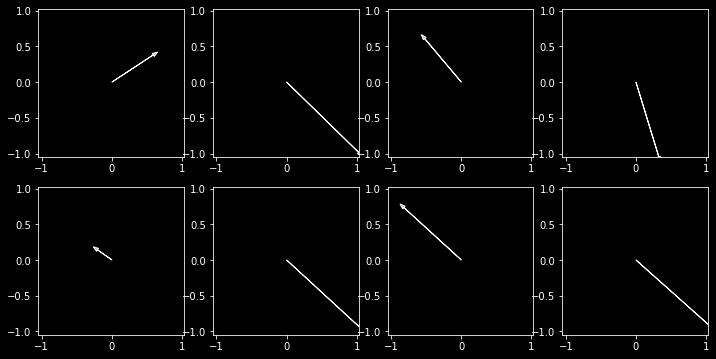

In [86]:
fig, ax = plt.subplots(2, x.shape[0], figsize=(x.shape[0]*3, x.shape[1]*3))
for a in ax.flatten():
    a.set_xlim(x.min(), x.max())
    a.set_ylim(x.min(), x.max())
for r in range(x.shape[0]):
    ax[0,r].arrow(0, 0, x[r,0], x[r,1], head_width=0.05)
    ax[1,r].arrow(0, 0, k[r,0], k[r,1], head_width=0.05)   

(-1.0471417595057255, 1.027459571914494)

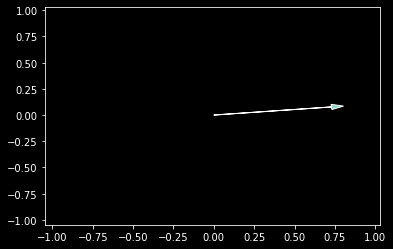

In [87]:
fig, ax = plt.subplots(1, 1)
ax.arrow(0, 0, gk[0], gk[1], head_width=0.05)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(x.min(), x.max())

In [ ]:
# values: (seq_length, d_model)
# keys: (seq_length, k_emb)
# global keys: (key_length, k_emb)

# (S, D) @ (D, K) -> (S, K)
# (Kl, S) @ (S, K) -> (Kl, K)

# generate keys (seq_length, k_emb)
# (S, D) @ (D, K) -> (S, K)
# generate global keys (key_length, k_emb)
# (Kl, S) @ (S, K) -> (Kl, K)
# map global keys to keys
# (S, K) . (Kl, K) -> (S, Kl, K)
# embed keys
# (S, Kl, K) -> (S, K)